<a href="https://colab.research.google.com/github/JiaWeiXie/ntub_ai_bi/blob/main/ntub_bi_20220517.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz \
#   && sudo tar -xzf ta-lib-0.4.0-src.tar.gz \
#   && sudo rm ta-lib-0.4.0-src.tar.gz \
#   && cd ta-lib/ \
#   && sudo ./configure --prefix=/usr \
#   && sudo make \
#   && sudo make install \
#   && cd ~ \
#   && sudo rm -rf ta-lib/ \
#   && pip install -U yfinance backtrader ta-lib

In [ ]:
! pip install yfinance backtrader rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import math
import datetime

import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.analyzers as btanalyzers

from rich import print

In [ ]:
import yfinance as yf

spy = yf.Ticker("SPY")
dataset = spy.history(period="max")
# dataset.to_csv("spy_max.csv")
dataset["2019"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02,233.141423,238.098462,233.112990,237.122208,126925200,0.0,0
2019-01-03,235.274039,235.596305,230.952044,231.463867,144140700,0.0,0
2019-01-04,234.667384,239.899280,234.269307,239.216858,142628800,0.0,0
2019-01-07,239.501217,242.591061,238.553410,241.103012,103139100,0.0,0
2019-01-08,243.415663,243.880079,240.742842,243.368256,102512600,0.0,0
...,...,...,...,...,...,...,...
2019-12-24,310.460897,310.509173,309.910411,310.229126,20270000,0.0,0
2019-12-26,310.634815,311.890313,310.625177,311.880646,30911200,0.0,0
2019-12-27,312.653213,312.711156,311.243220,311.803345,42528800,0.0,0


In [ ]:
class AllIn(bt.Sizer):
    def _getsizing(self, comminfo, cash, data, isbuy):
        # print(data[0], data[1], data.open[0], data.open[1])
        price = data.open[1]
        # print(f"${price:.2f}")
        position = self.broker.getposition(data)
        if isbuy:
            size = cash / price
        else:
            size = position.size

        return size

In [ ]:
class SMACross(bt.Strategy):
    def log(self, txt, dt=None):
        if not self.p.printlog:
            return

        dt = dt or self.datas[0].datetime.date(0)
        print(f"{dt}: {txt}", end="\n\n")
    
    params = dict(
        ma_period_short=5,
        ma_period_long=10,
        printlog=True,
    )

    def __init__(self):
        # sma_5 = bt.ind.SimpleMovingAverage(
        #     self.data.close,
        #     period=self.p.ma_period_short,
        #   )
        # sma_10 = bt.ind.SimpleMovingAverage(
        #     self.data.close,
        #     period=self.p.ma_period_long,
        #   )
        # # self.ma_diff = sma_5 - sma_10

        sma1 = bt.ind.SMA(period=self.p.ma_period_short)
        sma2 = bt.ind.SMA(period=self.p.ma_period_long)
        self.crossover = bt.ind.CrossOver(sma1, sma2)

        self.dataopen = self.datas[0].open

    def _log_tx(self, crossover, price, txdate=None, isbuy=False):
        crossover = int(crossover)
        txdate = txdate if txdate else self.datas[0].datetime.date(0)
        if isbuy:
            self.log(
                f"[bold green]buy[/], {crossover}, ${price:.2f}",
                txdate,
            )
        else:
            self.log(
                f"[bold red]sell[/], {crossover}, ${price:.2f}",
                txdate,
            )


    def next(self):
        if len(self.data) == self.data.buflen():
            if self.position:
                self.close(price=self.dataopen[0])
                self._log_tx(self.crossover[0], self.dataopen[0])

            return

        if not self.position and self.crossover[0] > 0:
            self.buy(price=self.dataopen[1])
            self._log_tx(
                self.crossover[0],
                self.dataopen[1],
                self.datas[0].datetime.date(1),
                isbuy=True,
            )
        elif self.position and self.crossover[0] < 0:
            self.close(price=self.dataopen[1])
            self._log_tx(
                self.crossover[0],
                self.dataopen[1],
                self.datas[0].datetime.date(1),
            )
      # else:
      #   self.log(f"crossover: {self.crossover[0]}")

In [ ]:
data = bt.feeds.PandasData(dataname=dataset["2019"])

# init cerebro
cerebro = bt.Cerebro()
# feed data
cerebro.adddata(data)
# add strategy
cerebro.addstrategy(SMACross)
# All In
# cerebro.addsizer(bt.sizers.AllInSizer)
# cerebro.addsizer(bt.sizers.SizerFix, stake = 1)
cerebro.addsizer(AllIn)
# add analyzer
cerebro.addanalyzer(btanalyzers.Returns, _name='returns')
cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='annual_return')
# run backtest
thestrats = cerebro.run()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


2019-03-15: buy, 1, $267.07

2019-03-27: sell, -1, $267.61

2019-04-02: buy, 1, $272.30

2019-05-07: sell, -1, $276.22

2019-05-22: buy, 1, $271.74

2019-05-24: sell, -1, $270.12

2019-06-10: buy, 1, $275.47

2019-07-02: sell, -1, $282.78

2019-07-03: buy, 1, $284.29

2019-07-23: sell, -1, $286.16

2019-07-29: buy, 1, $288.78

2019-08-02: sell, -1, $281.10

2019-08-15: buy, 1, $272.52

2019-08-16: sell, -1, $274.05

2019-08-23: buy, 1, $278.30

2019-08-29: sell, -1, $279.06

2019-09-04: buy, 1, $280.42

2019-09-25: sell, -1, $284.43

2019-10-15: buy, 1, $285.52

2019-12-06: sell, -1, $301.88

2019-12-11: buy, 1, $301.79

2019-12-31: sell, 0, $309.55

In [ ]:
thestrat = thestrats[0]
print("Returns:")
for k, v in thestrat.analyzers.returns.get_analysis().items():
    print(f"{k}:", f"{v * 100:.2f}%")

print("-" * 32)
print("Annual Return:")
for k, v in thestrat.analyzers.annual_return.get_analysis().items():
    print(f"{k}:", f"{v * 100:.2f}%")

Returns:

rtot: 12.39%

ravg: 0.05%

rnorm: 13.18%

rnorm100: 1318.50%

--------------------------------

Annual Return:

2019: 13.18%

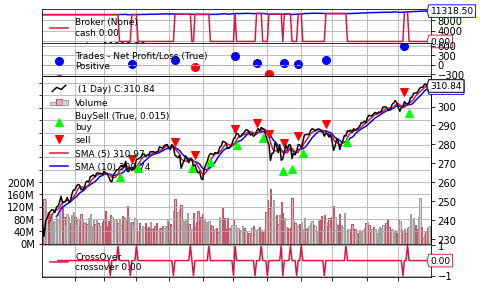

[[<Figure size 432x288 with 5 Axes>]]

In [ ]:
cerebro.plot(iplot=False)